01. PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow. First, we import the necessary modules.

In [36]:
import torch
from torch import nn        #nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Checkout PyTorch version
torch.__version__
RANDOM_SEED = 42

In [1]:
what_were_covering={1: "data (prepare and load)",
                    2: "build model",
                    3: "fitting the model to data (training)",
                    4: "making predictions and evaluating (inference)",
                    5: "Safe and load a model",
                    6: "Putting it all together"}

## 1. Data: Preparing and loading

Data can be almost anything in machine learning. 

* Excel spreadsheet
* Images of any kind
* Videos (YouTube has lots of data...)
* Audio like sonds or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a lienar regression formula to make a straight line with known **parameters**.

In [26]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1)  # We will see later on why we need this
y = weight * X + bias

In [27]:
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets 

Let's create a training and test set with our data.

In [15]:
# Create a train/test split
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test)

(40, 10)

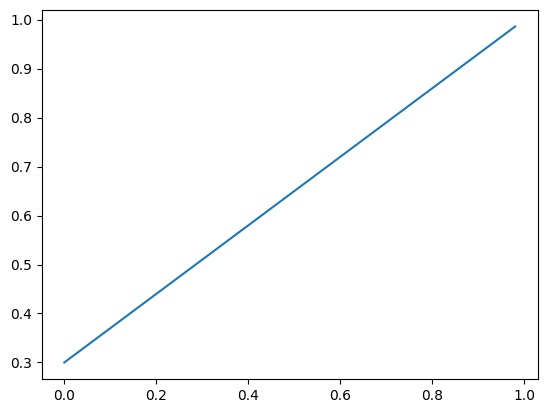

In [28]:
plt.plot(X,y)

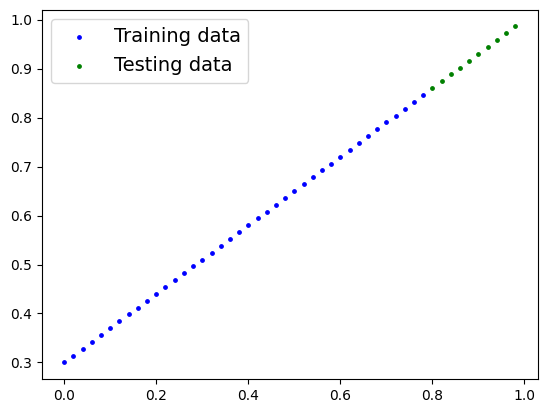

In [71]:
# Visualize data
def plot_data(train_data, train_labels, test_data, test_labels, predictions=None):
    #plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b",s=6, label="Training data")
    
    plt.scatter(test_data, test_labels, c="g",s=6, label="Testing data")
    
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=6, label="Predictions")
    plt.legend(prop={"size": 14})

plot_data(X_train, y_train, X_test, y_test)

## 2. Build our model

Our first PyTorch model!

What our model does:
* Start with random values for weight and bias
* Look at training data and adjust the random values to better represent the ideal values we used to create the data


How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [65]:
# Create a linear regression model class

class LinearRegressionModel(nn.Module):     # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, 
                                               requires_grad=True,      
                                               dtype=torch.float
                                               ))
        self.bias = nn.Parameter(torch.randn(1, 
                                            requires_grad=True,      
                                            dtype=torch.float
                                           ))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias

### PyTorch model building essentials

* `torch.nn` - contains all of the buidling blocks for neural networks
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - base class for all neural network modules, if you subclass it, you should overwrite the forward() function
* `torch.optim` - where the optimizers in PyTorch live, they will help with gradient descent
* `def forward()` - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation



### Checking the contents of our PyTorch model

Now that we've created a model, let's see what's inside...

So we can check out model parameters or what's inside our model using `.parameters()`

In [66]:
# Create a random seed
torch.manual_seed(RANDOM_SEED)

# Create an instance of our model
model0 = LinearRegressionModel()
list(model0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [67]:
model0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predicitive power, let's see how well it predicts `y_test` based on `X-test`.

When we pass data through our model, it's going to run it through the `forward()` method.

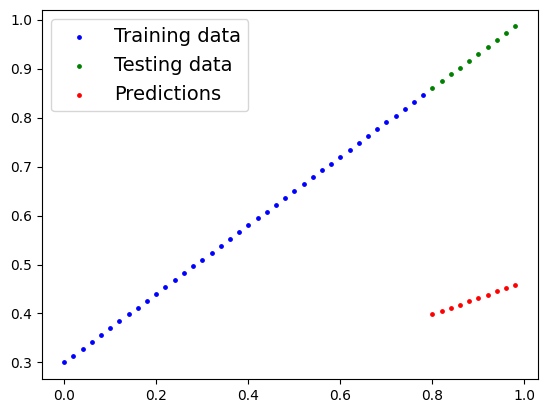

In [ ]:
# Make predictions with model - Why inference_mode? Turns off gradient tracking and therefore way faster (very important on large datasets with large models!). 

with torch.inference_mode():
    y_preds = model0(X_test)

# You cna also do something similar with `torch.no_grad()`, however, `torch.inference_mode()` is preferred
#  with torch.no_grad():
#    y_preds = model0(X_test)

plot_data(X_train, y_train, X_test, y_test, y_preds)

Randomly initialized network does not perform well.

## 3. Train model

The whole idea of training is for a model to move from some unknown, possibly random, parameters to some known parameters. Or in other words, from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function. Things we need to train:

* **Loss function**: A function to measure how wrong our model's predictions are to the ideal outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters.

And for PyTorch, we need:
* A training loop
* A testing loop

In [ ]:
# Setup a loss function

loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD()